# Entrenamiento y comparación de modelos

## Preparación de los datos para el modelo

In [2]:
# Importar librerias necesarias
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

Cargar y organizar el dataset para la predicción

In [3]:
df = pd.read_csv('final_dataframe_churn_prediction.csv')
# Separa las características (X) de la variable objetivo (y, que es is_churned)
X = df.drop(columns=["is_churned"], axis = 1).copy()
y = df['is_churned'].copy()
# Divide el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Visualiza conjunto de datos de train
X_train

,order_count_historic,gmv_historic,AOV_historic,antiquity_days,visits_count_3m,canceled_orders,tickets_finales,mean_order_lapse,new_skus_within_3m,orders_count_delta_1m,gmv_delta_1m,distinct_skus_delta_1m,orders_count_delta_2m,gmv_delta_2m,distinct_skus_delta_2m,warehouse_Bogota,sub_categoria_Ambientadores,sub_categoria_Complementos y vitaminas
1209,7,4.982586e+06,7.117980e+05,136,6,0,0,22.666667,5,0.000000,0.223456,0.181818,-0.800000,-0.673311,-0.555556,1.0,0.0,0.0
5244,130,1.793423e+07,1.379556e+05,454,21,0,0,3.519380,131,-0.235294,0.263366,0.072165,-0.268293,0.063617,-0.067039,1.0,0.0,0.0
3036,29,4.308398e+07,1.485654e+06,574,8,0,0,20.500000,72,0.000000,0.384690,0.350000,1.000000,0.230457,0.041322,1.0,0.0,0.0
1158,5,9.082359e+05,1.816472e+05,148,8,0,0,37.000000,5,0.000000,0.223456,0.181818,-0.666667,-0.765666,-0.687500,1.0,0.0,0.0
5204,178,7.668532e+07,4.308164e+05,417,34,0,0,2.355932,137,-0.133333,0.124538,0.016287,0.166667,-0.044767,0.022026,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,52,2.620833e+07,5.040064e+05,448,11,0,0,8.784314,22,-0.500000,-0.744108,-0.615385,0.500000,0.164743,-0.131579,0.0,0.0,0.0
3772,8,1.861974e+06,2.327468e+05,59,8,0,0,8.428571,61,0.000000,0.223456,0.181818,0.058824,0.211494,0.198953,1.0,0.0,0.0
5191,283,1.640629e+07,5.797276e+04,562,7,0,0,1.992908,21,-0.562500,-0.681850,-0.604651,-0.041667,-0.013422,0.268293,0.0,0.0,0.0
5226,407,4.802106e+07,1.179879e+05,535,12,0,0,1.317734,52,-0.720000,-0.152650,-0.100917,-0.111111,0.176199,0.190141,1.0,0.0,0.0


## Descripción de las variables

Nótese que cada registro describe las variables comportamentales de un cliente.

- is_churned: Variable objetivo, 1 indica que el cliente es un cliente actualmente 'churn', 0 indica que el cliente no es 'churn' en otras palabras está activo.
- order_count_historic: Conteo histórico de órdenes.
- gmv_historic: Sumatoria del gmv histórico (Gross Merchandise Value) en COP.
- AOV_historic: Average order value del cliente.
- antiquity_days: Días transcurridos desde la primera órden del cliente.
- visits_count_3m: Conteo de visitas de la empresa al cliente en los tres meses anteriores a su última compra.
- canceled_orders: Conteo de ordenes canceladas por parte del cliente.
- tickets_finales: Conteo de tickets abiertos por el cliente. Un ticket es un contacto con customer_service
- mean_order_lapse: Lapso promedio entre órdenes
- new_skus_within_3m: Cantidad de productos nuevos que el cliente compró en los tres meses previos a su última órden
- orders_count_delta_1m: Variación entre el conteo de órdenes del último més de actividad del cliente versus el més anterior. Se calcula como ordenes_ultimo_mes - ordenes_mes_anterior / ordenes_mes_anterior
- gmv_delta_1m: Variacion en el gmv (ultimo més de actividad)
- distinct_skus_delta_1m: Variacion en la cantidad de productos que se compra (ultimo més de actividad)
- orders_count_delta_2m: Variación entre el conteo de órdenes (dos últimos meses de actividad)
- gmv_delta_2m: Variacion en el gmv (dos últimos meses de actividad)
- distinct_skus_delta_2m: Variacion en la cantidad de productos que se compra (dos últimos meses de actividad)
- warehouse_Bogota: El cliente pertenece a la ciudad de Bogotá
- sub_categoria_Ambientadores: El cliente compra los productos de la sub categoría Ambientadores
- sub_categoria_Complementos y vitaminas: El cliente compra los productos de la sub categoría Complementos y vitaminas

## Planteamiento de modelos
Acontinuación se probarán los siguientes modelos de clasificación: KNN, Regresión Logística, SVM, Random Forest, y XGBoost. Se utilizarán las siguientes configuraciones. 

**SMOTE para el manejo de desequilibrio de clases**

Dada la naturaleza desequilibrada del conjunto de datos, donde la cantidad de clientes que no realizan churn es mayor que aquellos que sí lo hacen, se utilizará la técnica de SMOTE (Synthetic Minority Over-sampling Technique). SMOTE ayudará a equilibrar las clases mediante la generación de ejemplos sintéticos de la clase minoritaria, permitiendo así que nuestros modelos aprendan de manera más efectiva de ambas clases. Se compararán los resultados de los modelos con y sin SMOTE
 
**F1 Score como métrica**

Para evaluar el rendimiento de estos modelos, se ha seleccionado el F1 Score como la métrica principal. Esta métrica es especialmente útil en situaciones de desequilibrio de clases, ya que combina la precisión y la sensibilidad (recall), proporcionando un equilibrio entre la identificación correcta de los clientes que realizarán churn y aquellos que no.

**Descripción de modelos utilizados**
- Regresión Logística: Un modelo de clasificación lineal que estima la probabilidad de que una instancia pertenezca a una clase específica. Es útil para identificar la relación entre las características independientes y la probabilidad de churn.
- K-Nearest Neighbors (KNN): Un modelo basado en vecinos que clasifica una instancia según las etiquetas de las 'K' instancias más cercanas. Utilizado para encontrar clientes con características similares y predecir el churn.
- Random Forest: Ensamble de árboles de decisión que combina múltiples árboles para mejorar la precisión y robustez, siendo menos susceptible al sobreajuste.
- Extreme Gradient Boosting (XGBoost): Un ensamble que construye árboles de manera secuencial, cada uno corrigiendo los errores del anterior, eficaz para capturar relaciones complejas entre las características y el churn.

Cada uno de estos modelos ofrece una perspectiva única sobre el problema, permitiéndonos abordar la predicción de churn desde varios ángulos. La evaluación de estos modelos nos proporcionará valiosos insights sobre su rendimiento y adecuación para nuestro conjunto de datos específico.

### Prueba de todos los modelos sin ajuste de hiperparámetros

Este enfoque implica evaluar diversos modelos de clasificación en su configuración por defecto, sin realizar ajustes finos en sus hiperparámetros. Los hiperparámetros son configuraciones externas al modelo que influyen en su comportamiento y rendimiento, como la profundidad de un árbol en un modelo de Random Forest o el número de vecinos en KNN.

En esta etapa, el objetivo es obtener una comprensión inicial de cómo cada modelo se desempeña con los valores predeterminados de sus hiperparámetros. Esto proporciona una base para comparar los modelos entre sí y determinar cuáles muestran mayor potencial para el problema de predicción de churn. Posteriormente, para los modelos más prometedores, se pueden realizar ajustes en sus hiperparámetros buscando optimizar su rendimiento.

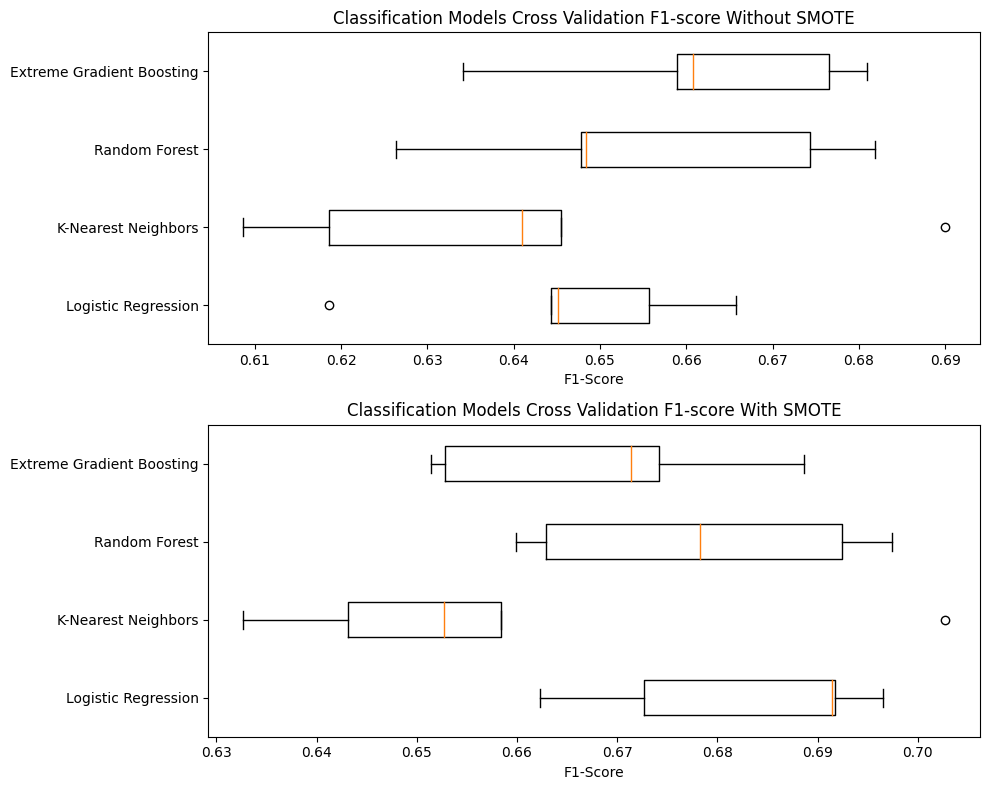

In [4]:
# Crear una función para evualar los modelos, con dos argumentos: uno para el modelo y otro para smote
def evaluate_models(models, use_smote=False):
    results = [] # Lista vacía con los resultados
    # Iterar a traves de cada modelo en el diccionario models
    for name, model in models.items():
        # Establecer 42 en el parametro random_state para asegurar reproducibilidad de resultados
        if "random_state" in model.get_params().keys():
            model.set_params(random_state=42)
        # Definir los pasos para el pipeline
        steps = [
            ('imputer', IterativeImputer(random_state=0)),
            ('scaler', StandardScaler()),
            ('classifier', model)
            ]
        # Incluir smote si es necesario, si es True
        if use_smote:
            steps.insert(1, ('smote', SMOTE(random_state=42)))
        # Crear el Pipeline o ImbPipeline si se usa SMOTE    
        pipeline = ImbPipeline(steps) if use_smote else Pipeline(steps)
        # Validación cruzada con 5 divisiones para evaluar rendimiento del modelo 
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        # Se usa la métrica F1, que es útil cuando hay desequilibrio de clases 
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring="f1")
        results.append(cv_scores)
    return results

# Definir modelos a evaluar 
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Extreme Gradient Boosting": xgb.XGBClassifier(),
    # "Support Vector Classifier": SVC(probability=True)  # 'probability=True' needed for scoring recall in SVC,
}

# Evaluar ambos resultados. Sin SMOTE
results_without_smote = evaluate_models(models, use_smote=False)
# Con SMOTE
results_with_smote = evaluate_models(models, use_smote=True)

# Graficar los resultados
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
# Sin SMOTE
axs[0].boxplot(results_without_smote, labels=models.keys(), vert=False)
axs[0].set_title('Classification Models Cross Validation F1-score Without SMOTE')
axs[0].set_xlabel('F1-Score')
# Con SMOTE
axs[1].boxplot(results_with_smote, labels=models.keys(), vert=False)
axs[1].set_title('Classification Models Cross Validation F1-score With SMOTE')
axs[1].set_xlabel('F1-Score')

plt.tight_layout()
plt.show()

### Ajuste de hiperparámetros

Model saved as KNN.pkl


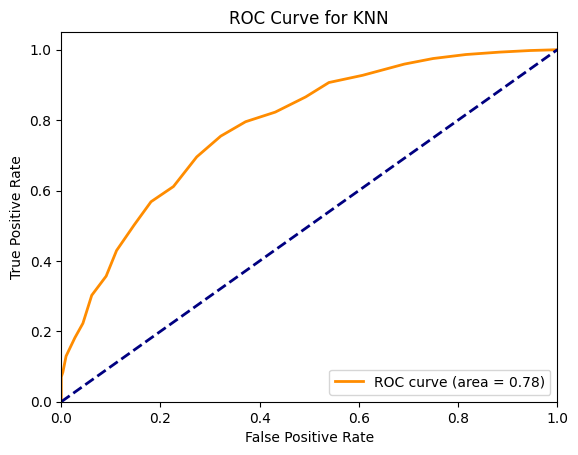

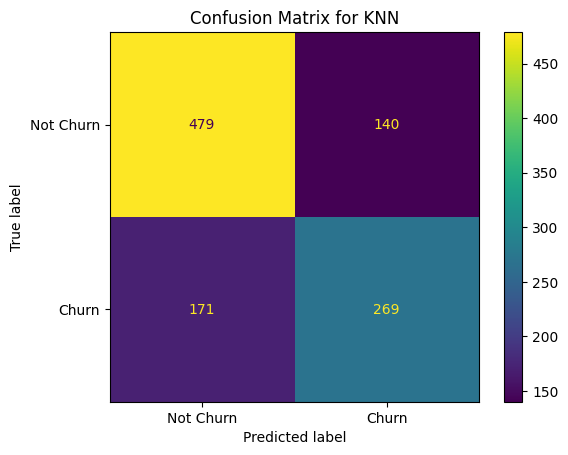

Model saved as KNN_with_SMOTE.pkl


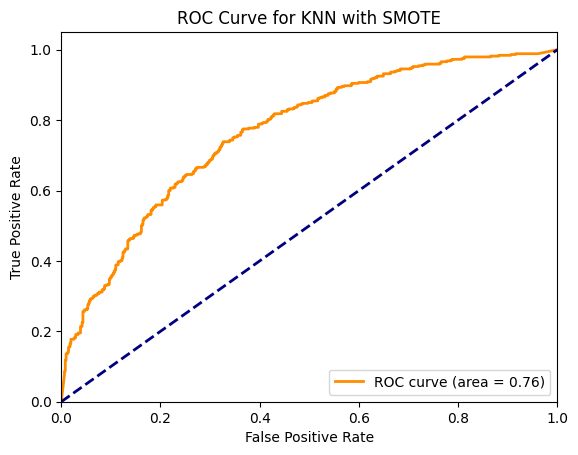

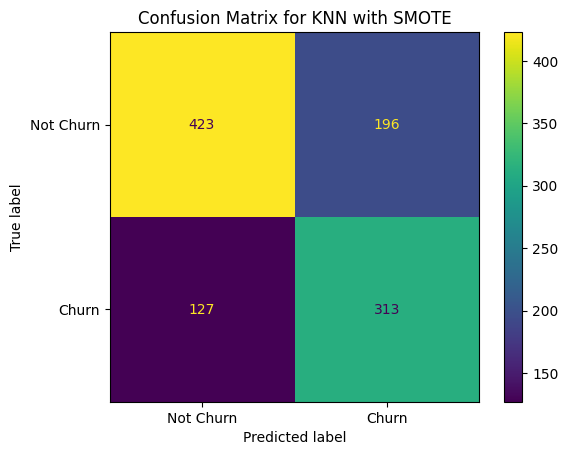

Model saved as LogisticRegression.pkl


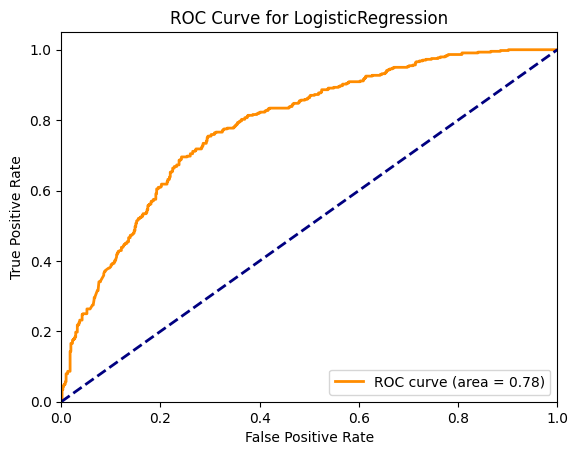

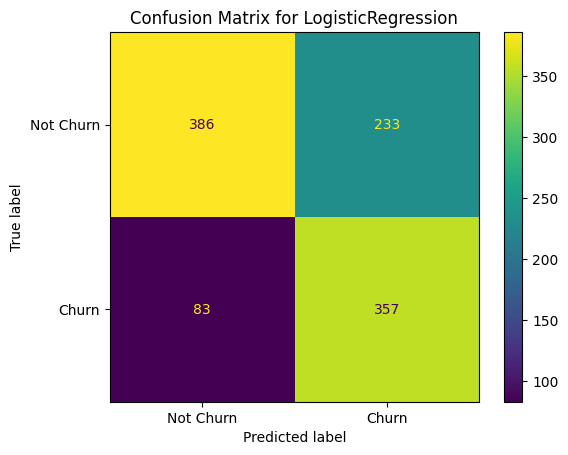

Model saved as LogisticRegression_with_SMOTE.pkl


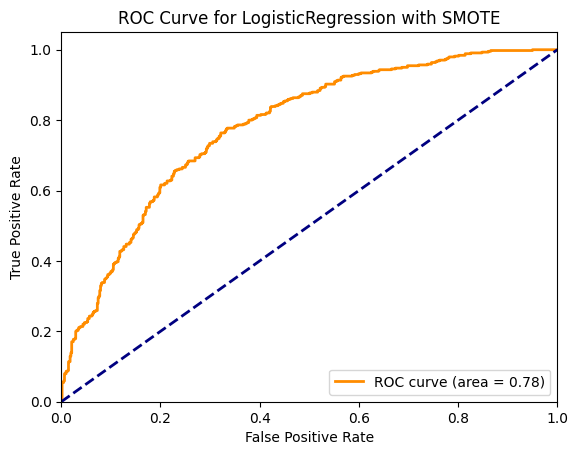

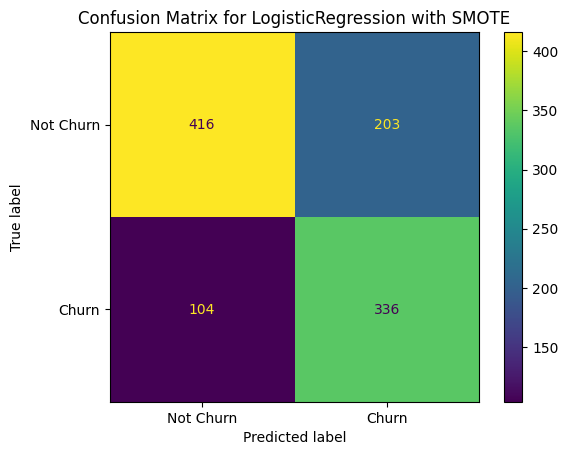

Model saved as RandomForest.pkl


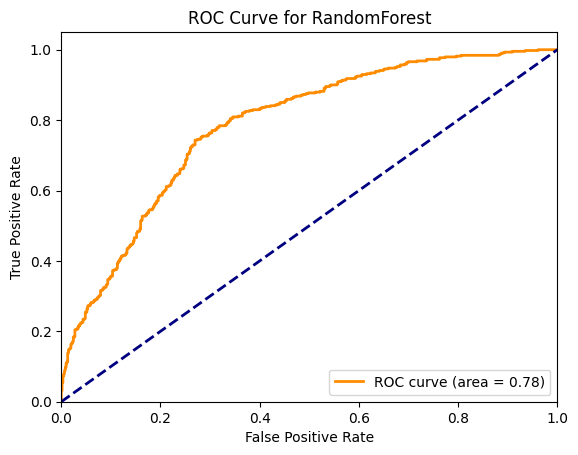

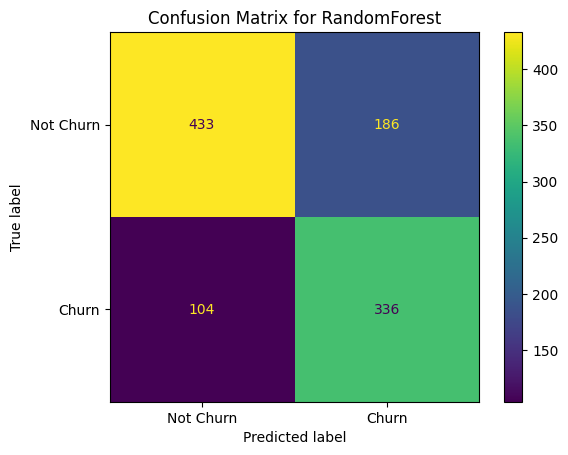

Model saved as RandomForest_with_SMOTE.pkl


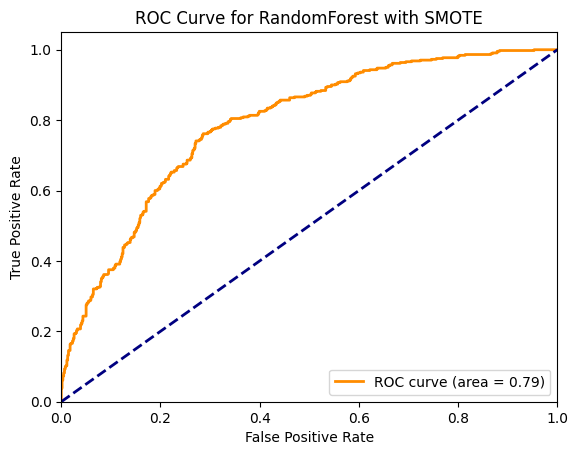

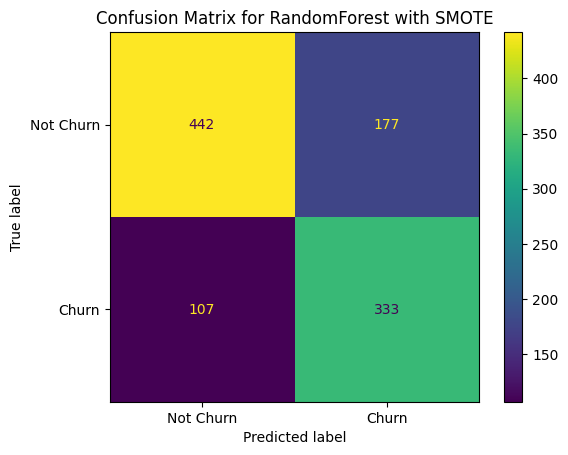

Model saved as XGBoost.pkl


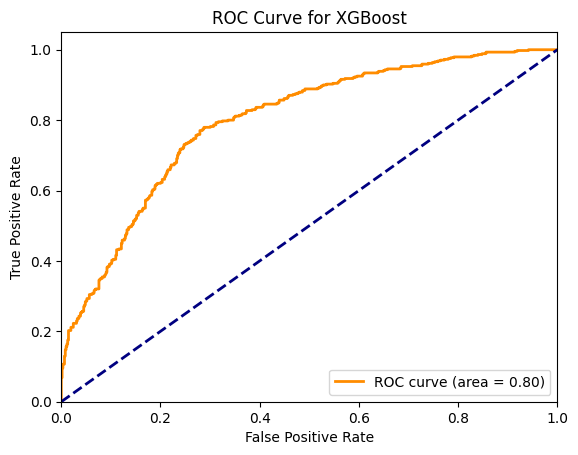

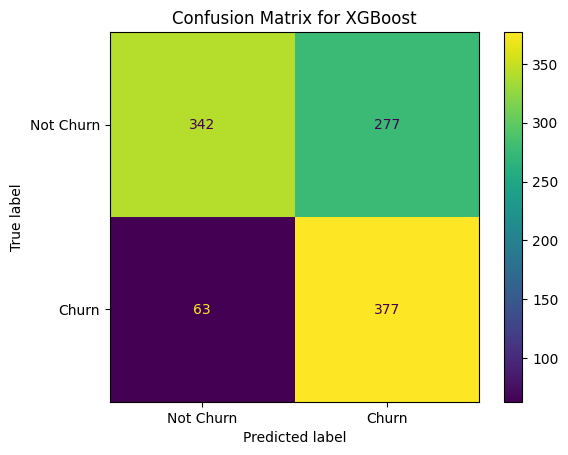

Model saved as XGBoost_with_SMOTE.pkl


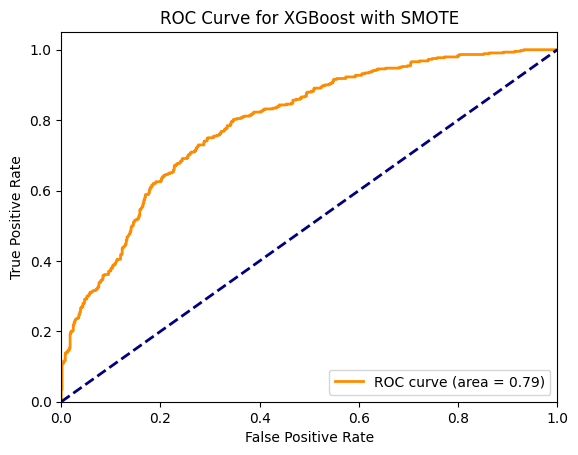

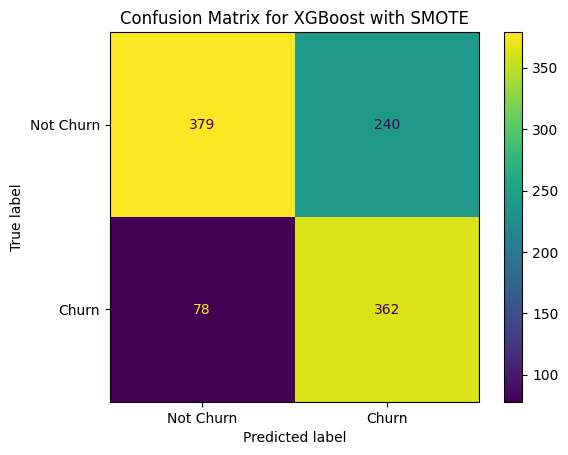

,accuracy,recall,precision,f1,AUC,best_cross_val_score
KNN,0.706327,0.611364,0.657702,0.633687,0.782944,0.642123
KNN With Smote,0.694995,0.711364,0.614931,0.659642,0.764921,0.676299
Logistic Regression,0.701605,0.811364,0.605085,0.693204,0.784397,0.687211
Logistic Regression With Smote,0.710104,0.763636,0.623377,0.686415,0.781060,0.685079
Random Forest,0.726157,0.763636,0.643678,0.698545,0.784730,0.697048
Random Forest With Smote,0.731822,0.756818,0.652941,0.701053,0.789033,0.697605
XGBoost,0.678942,0.856818,0.576453,0.689214,0.796870,0.704833
XGBoost With Smote,0.699717,0.822727,0.601329,0.694818,0.791794,0.709674


In [14]:
# Crear función para entrenar, evaular y registrar los modelos
def train_and_log_model(classifier, params, model_name, use_smote=False):
    if "random_state" in classifier.get_params().keys():
        classifier.set_params(random_state=42)
    #  Definir los pasos para el pipeline
    steps = [
        ('imputer', IterativeImputer()),
        ('scaler', StandardScaler()),
        (model_name, classifier)
        ]
    # Incluir smote si es necesario, si es True
    if use_smote:
        steps.insert(1, ('smote', SMOTE(random_state=42)))
        model_name += ' with SMOTE'
    
    # Crear el Pipeline o ImbPipeline si se usa SMOTE    
    pipeline = ImbPipeline(steps) if use_smote else Pipeline(steps)
    # Validación cruzada con 5 divisiones para evaluar rendimiento del modelo 
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    # Busqueda aleatoria de hiperparámetros con F1 como métrica y 50 iteraciones 
    model = RandomizedSearchCV(pipeline, param_distributions=params, n_iter=50, cv=kf, scoring='f1', random_state=42)
    # Entrenar el modelo
    model.fit(X_train, y_train)
    # Guardar el modelo
    model_filename = f'{model_name.replace(" ", "_")}.pkl'
    joblib.dump(model.best_estimator_, model_filename)
    print(f'Model saved as {model_filename}')

    # Hacer las predicciones y calcular las métricas
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1] if hasattr(classifier, "predict_proba") else None
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred), 
        # Precisión general del modelo (fracción de predicciones correctas)
        "recall": recall_score(y_test, y_pred), 
        # Sensibilidad (capacidad del modelo para detectar la clase positiva)
        "precision": precision_score(y_test, y_pred), 
        # Precisión (fracción de predicciones correctas entre las clasificadas como positivas)
        "f1": f1_score(y_test, y_pred), 
        # F1 Score (media armónica de precisión y sensibilidad)
        "AUC": roc_auc_score(y_test, y_pred_probs) if y_pred_probs is not None else None, 
        # Área Bajo la Curva ROC (mide la capacidad del modelo para distinguir entre las clases; solo se calcula si las probabilidades de predicción están disponibles).
        "best_cross_val_score": model.best_score_
        #  El mejor puntaje de validación cruzada obtenido durante la optimización de hiperparámetros
    }

    # Calcular y graficar la cuva ROC y AUC
    if y_pred_probs is not None: # Verfica las probabilidades de predicción
        # Calcular  la tasa de falsos positivos (fpr) y la tasa de verdaderos positivos (tpr) para diferentes umbrales de decisión.
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        # Calcular AUC o área bajo la curva ROC
        roc_auc = auc(fpr, tpr) 

        # Graficar resultados
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    # Visualización Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churn', 'Churn'])
    disp.plot()
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return metrics

# Definir parametros de los modelos
# KNN 
knn_params = {
    'KNN__n_neighbors': np.arange(1, 31, 3), 
    'KNN__weights': ['uniform', 'distance'], 
    'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] 
}

logreg_params = {
    'LogisticRegression__C': [0.01, 0.1, 1, 10],
    'LogisticRegression__penalty': ['l1', 'l2'],
    'LogisticRegression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'LogisticRegression__max_iter': [100, 500, 1000],
    'LogisticRegression__class_weight': [None, 'balanced'],
    'LogisticRegression__fit_intercept': [True, False]
}

svc_params = {
    'Support_Vector_Classifier__C': [0.1, 1, 10, 100],
    'Support_Vector_Classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'Support_Vector_Classifier__gamma': [0.1, 1, 'auto', 'scale'],
    'Support_Vector_Classifier__class_weight': [None, 'balanced'],
    'Support_Vector_Classifier__probability': [True]
}

rf_params = {
    'RandomForest__n_estimators': [10, 50, 100, 200, 300, 500],
    'RandomForest__criterion': ['gini', 'entropy'],
    'RandomForest__max_depth': [None, 3, 5, 7, 10, 20, 30],
    'RandomForest__min_samples_split': [2, 5, 10],
    'RandomForest__min_samples_leaf': [1, 2, 4],
    'RandomForest__bootstrap': [True, False],
    'RandomForest__class_weight': [None, 'balanced']
}

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
xgb_params = {
    'XGBoost__learning_rate': [None, 0.001, 0.01, 0.1],
    'XGBoost__n_estimators': [50, 100, 200],
    'XGBoost__max_depth': [None, 3, 5, 7],
    'XGBoost__subsample': [0.8, 0.9, 1.0],
    'XGBoost__colsample_bytree': [0.7, 0.8, 0.9],
    'XGBoost__gamma': [0.1, 0.2],
    'XGBoost__lambda': [0.1, 1.0],
    'XGBoost__alpha': [0.1, 1.0],
    'XGBoost__scale_pos_weight': [3, 4, 5, scale_pos_weight],
    'XGBoost__max_delta_step': [1, 2, 5, 10]
}

# Guardar resultados
results = {}

# Entrenar modelos y guardar resultados. Con y Sin SMOTE 
results['KNN'] = train_and_log_model(KNeighborsClassifier(), knn_params, 'KNN')
results['KNN With Smote'] = train_and_log_model(KNeighborsClassifier(), knn_params, 'KNN', use_smote=True)

results['Logistic Regression'] = train_and_log_model(LogisticRegression(), logreg_params, 'LogisticRegression')
results['Logistic Regression With Smote'] = train_and_log_model(LogisticRegression(), logreg_params, 'LogisticRegression', use_smote=True)

# results['SVC'] = train_and_log_model(SVC(), svc_params, 'Support_Vector_Classifier')
# results['SVC With Smote'] = train_and_log_model(SVC(), svc_params, 'Support_Vector_Classifier', use_smote=True)

results['Random Forest'] = train_and_log_model(RandomForestClassifier(), rf_params, 'RandomForest')
results['Random Forest With Smote'] = train_and_log_model(RandomForestClassifier(), rf_params, 'RandomForest', use_smote=True)

results['XGBoost'] = train_and_log_model(xgb.XGBClassifier(), xgb_params, 'XGBoost')
results['XGBoost With Smote'] = train_and_log_model(xgb.XGBClassifier(), xgb_params, 'XGBoost', use_smote=True)

results_df = pd.DataFrame(results).T
results_df

**Descripción métricas**

Al evaluar los modelos de clasificación es crucial entender las métricas clave que reflejan el rendimiento de cada modelo. 
- Accuracy mide la proporción total de predicciones correctas y es un indicador general del rendimiento.
- Recall se enfoca en la capacidad del modelo para identificar correctamente los casos positivos (Churned) correctamente identificados. 
- Precision mide la proporción de predicciones positivas que son realmente correctas. 
- F1 Score combina precision y recall en una sola métrica que es particularmente útil en situaciones de clases desequilibradas. 
- AUC mide la capacidad del modelo para distinguir entre clases, y un valor cercano a 1 indica una excelente capacidad de discriminación. 
- Best Cross-Val Score indica el mejor valor de la métrica F1-score en el proceso de kfold cross validation.

**Análisis de los resultados de las métricas**

Al observar las métricas de la tabla, se pueden considerar las siguientes interpretaciones:

- Los *modelos con SMOTE* tienden a tener un recall más alto, evidenciando su fortaleza para detectar clientes en riesgo de churn. Aunque esto podría resultar en una menor precisión, el uso de SMOTE demuestra ser efectivo para el objetivo principal de capturar la mayor cantidad de clientes churn.
-  El modelo de *Regresión Logística con SMOTE* destaca por su equilibrio entre las métricas, manteniendo un recall alto sin comprometer excesivamente la precisión. Su F1 Score es competitivo, lo que indica un balance adecuado entre precisión y sensibilidad.
- El modelo *XGBoost* destaca, especialmente con SMOTE, pues muestra el recall más alto y el F1 Score más alto, aunque con una precisión más baja, lo que indica un número mayor de falsos positivos. 

En resumen, el *XGBoost con SMOTE* sobresale como el modelo preferido para identificar clientes en riesgo de churn, gracias a su alto recall y su sólido F1 Score. A pesar de la disminución en precisión, este modelo se alinea mejor con la estrategia de negocio de priorizar la identificación de la mayor cantidad de churn posible, permitiendo así implementar acciones proactivas de retención. La elección de este modelo se justifica en su capacidad para maximizar la detección de clientes potencialmente churn, un aspecto crítico para cualquier estrategia de retención efectiva.

### Importar modelos

In [17]:
# Función para cargar un modelo
def load_model(model_filename):
    return joblib.load(model_filename)

# Ejemplo para cada uno de los modelos
loaded_knn_model = load_model('KNN.pkl')
loaded_knn_with_smote_model = load_model('KNN_with_SMOTE.pkl')
loaded_logistic_regression_model = load_model('LogisticRegression.pkl')
loaded_logistic_regression_with_smote_model = load_model('LogisticRegression_with_SMOTE.pkl')
loaded_random_forest_model = load_model('RandomForest.pkl')
loaded_random_forest_with_smote_model = load_model('RandomForest_with_SMOTE.pkl')
loaded_xgboost_model = load_model('XGBoost.pkl')
loaded_xgboost_with_smote_model = load_model('XGBoost_with_SMOTE.pkl')


**Verificación de la calidad del archivo .pkl calculando métricas de un modelo**

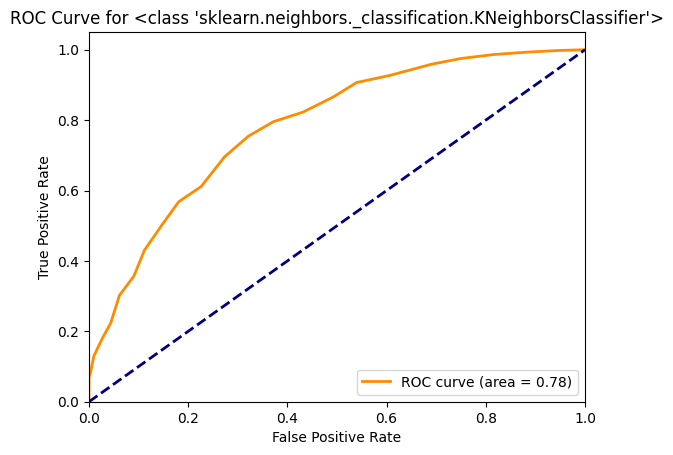

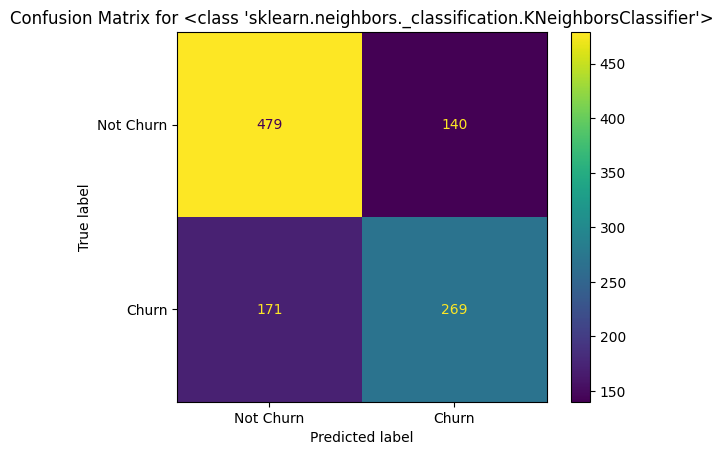

In [18]:
# Carga de modelo knn de prueba
model = loaded_knn_model
classifier = model
model_name = str(model.steps[-1][1].__class__)

# Hacer predicciones y calcular métricas
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)[:, 1] if hasattr(classifier, "predict_proba") else None
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred_probs) if y_pred_probs is not None else None,
}

# Calcular curva de ROC
if y_pred_probs is not None:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Visualizar curva de ROC 
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Graficar matrix de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.title(f'Confusion Matrix for {model_name}')
plt.show()